# Installation

In [40]:
!pip install scikit-image pandas matplotlib tqdm  torchinfo tensorboard wandb scikit-learn vit-pytorch


Defaulting to user installation because normal site-packages is not writeable


# Imports

In [47]:
import os
import torch
import psutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from util import format
from torch.utils.data import DataLoader
from torchinfo import summary
import torchvision.transforms as transforms
from util import run_experiment
from datasets import DeepLenseClassificationDataset
from vit_pytorch import ViT, SimpleViT
from vit_pytorch.mobile_vit import MobileViT

# CONFIG

In [29]:
class CONFIG:
    BATCH_SIZE = 8
    EPOCHS = 30
    UPDATES = 6
    GAMMA_FACTOR = 0.5
    
    # limit the data to prototype faster
    DATA_LIMIT = 100
    
    CLASSES = 3
    ROUND_NUMBER = 3
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    TASK_NAME = "DeepLense2024_task1"

In [30]:
memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}, RAM free : {format(memory_start.free)}")

RAM used : 6.15GB, RAM free : 1016.3MB


# Loading the dataset

In [33]:
from datasets import DeepLenseClassificationDataset

_transforms=transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1)),
    datasets.ApplyNoise(mean=0, std=0.05 / 3),
])

In [34]:



training_data = DeepLenseClassificationDataset(os.path.join(".", "Data", "dataset", "train"), data_limit=CONFIG.DATA_LIMIT, randomize_dataset=False,
                                               mean=0, std=1, transforms=_transforms)
train_dataloader = DataLoader(training_data, batch_size=CONFIG.BATCH_SIZE, shuffle=True)


mean, std = training_data.mean, training_data.std

val_data = DeepLenseClassificationDataset(os.path.join(".", "Data", "dataset", "val"), data_limit=CONFIG.DATA_LIMIT, randomize_dataset=False,
                                               mean=0, std=1)
val_dataloader = DataLoader(val_data, batch_size=CONFIG.BATCH_SIZE, shuffle=True)

memory = psutil.virtual_memory()
print(f"RAM used : {format(memory.used)}, RAM free : {format(memory.free)}, dataset used : {format(memory_start.free - memory.free)}")

preprocessing: 100%|██████████| 300/300 [00:00<00:00, 14668.30it/s]

RAM used : 6.2GB, RAM free : 852.15MB, dataset used : 164.16MB


## Get the batch for prototyping

In [35]:
# Get the sample batch to prototype with models
x, y = next(iter(train_dataloader))
id2name = [v.split("/")[-1] for v in training_data.class_folders] 

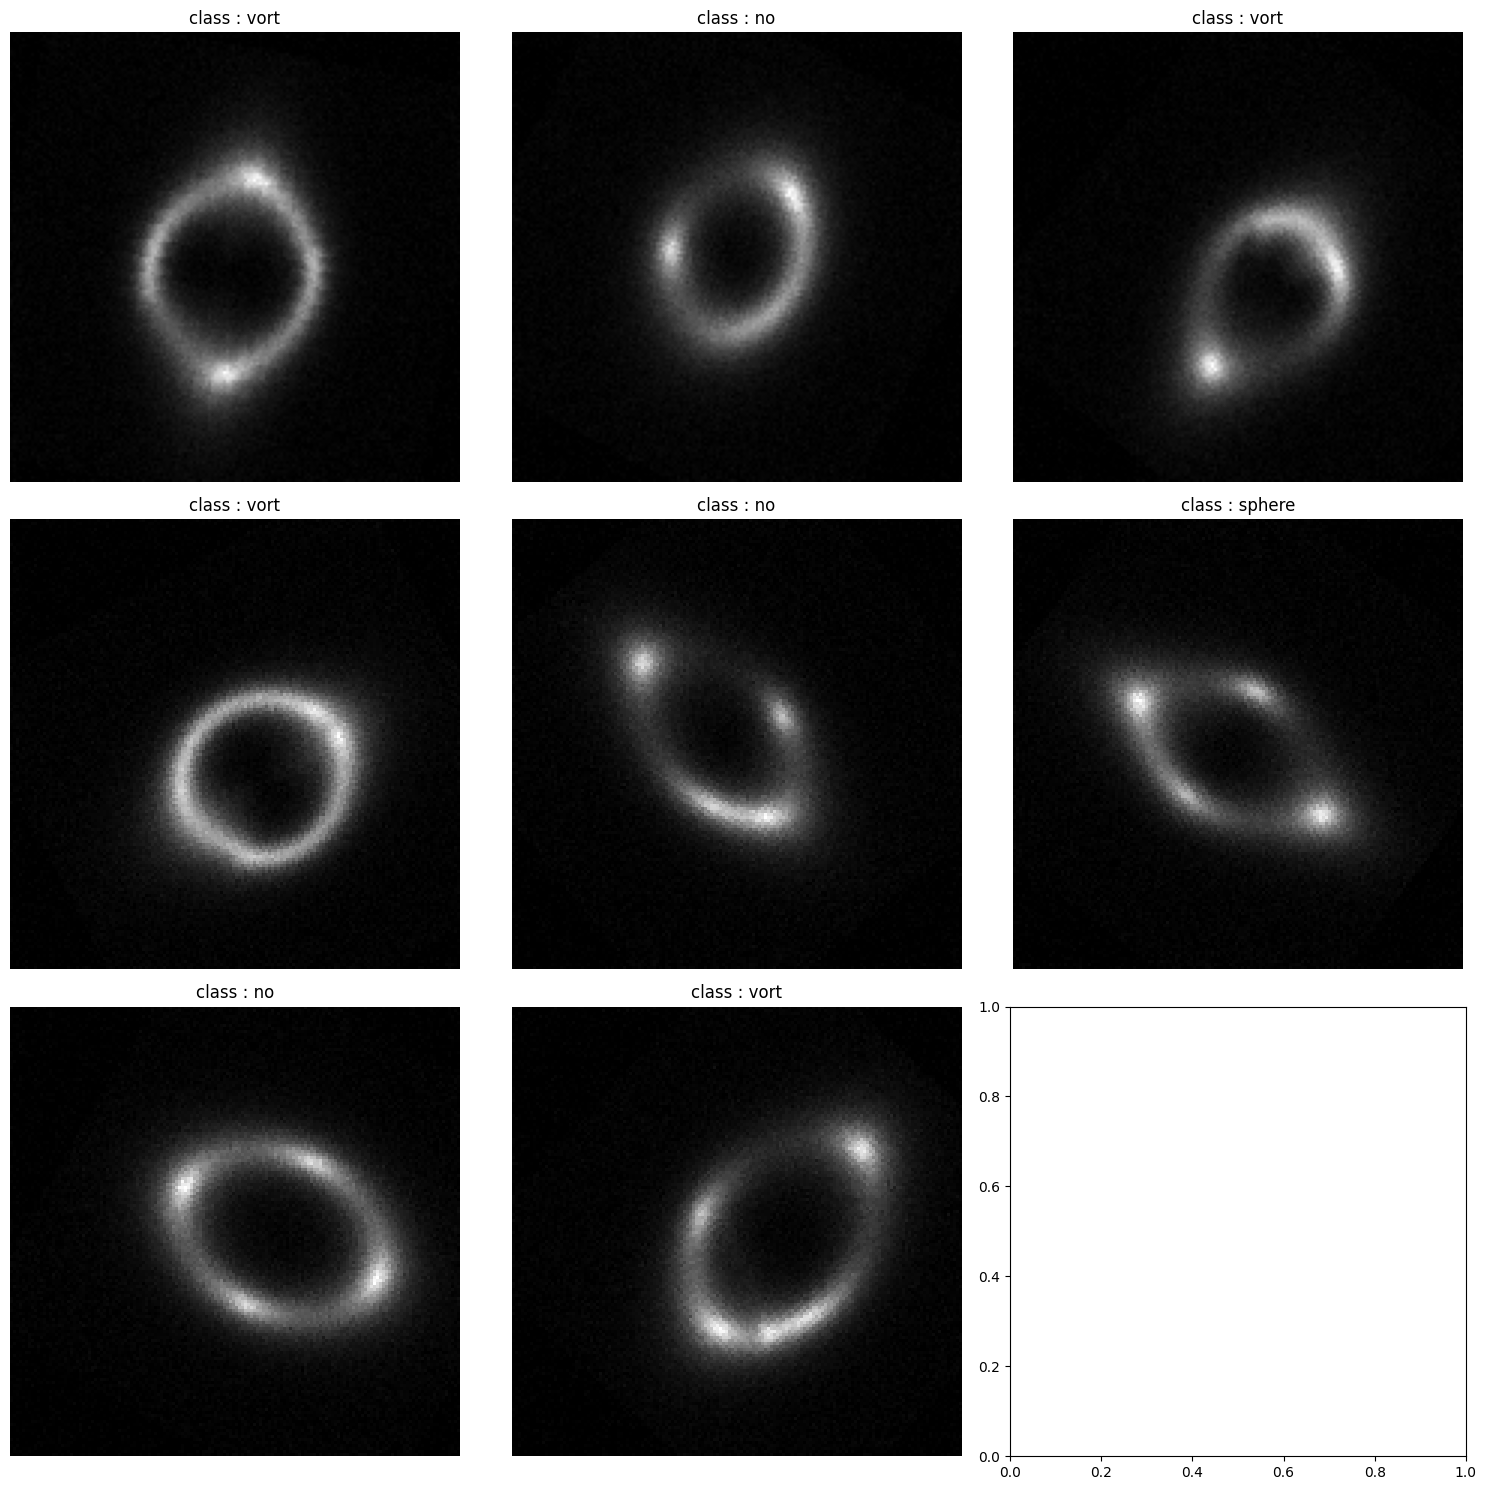

In [62]:
import matplotlib.pyplot as plt 
import math 
plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

fig, axes = plt.subplots(plot_size, plot_size, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i >= len(x):
        break
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    img = x[i].numpy().transpose(1, 2, 0)
    
    ax.imshow(img, cmap="gray")
    ax.set_title(f"class : {id2name[y[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Resnet-based

In [63]:
from torchvision.models import resnet18, resnet34, resnet50

class CNN_resnet(nn.Module):
    def __init__(self, base="resnet18"):
        super(CNN_resnet, self).__init__()
        # the resnet model was trained on imagenet, it's not really applicable in this situation
        if base.lower() == "resnet18":
            self.backend = resnet18(None)
        elif base.lower() == "resnet34":
            self.backend = resnet34(None)
        elif base.lower() == "resnet50":
            self.backend = resnet50(None)
        else:
            raise Exception("incorrect backbone")
    
        
        # make one channel 
        self.backend.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

        # output 3 classes
        self.backend.fc = nn.Linear(512, CONFIG.CLASSES, bias=True)
        

    def forward(self, x):
        # Applying convolutional layers with ReLU and pooling
        x = self.backend(x)
        return x

# Create the CNN model instance
model = CNN_resnet(base="resnet18").to(CONFIG.DEVICE)

/home/mlewand/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


## Resnet18

In [64]:
model(x.float().to(CONFIG.DEVICE)).shape
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

Layer (type:depth-idx)                        Param #
CNN_resnet                                    --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
│    └─AdaptiveA

In [66]:
import util
from importlib import reload

reload(util)

util.run_experiment(Model=CNN_resnet, 
               run_name="resnet18", 
               model_parameters={"base":"resnet18"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "resnet18.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

/home/mlewand/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
EPOCH : 0, average loss : 1.1487949506232613, lr=2.2196411766036502e-05: 100%|██████████| 38/38 [00:02<00:00, 17.15it/s]
examples seen so far : 300, accuracy = 0.343, AUC ROC = 0.532: 100%|██████████| 38/38 [00:00<00:00, 51.84it/s]
examples seen so far : 300, accuracy = 0.317, AUC ROC = 0.476: 100%|██████████| 38/38 [00:00<00:00, 113.95it/s]


Saving metric with accuracy=0.31666666666666665 (previous : 0)


EPOCH : 1, average loss : 1.112668365240097, lr=6.0639995510394165e-05: 100%|██████████| 38/38 [00:01<00:00, 30.98it/s] 
examples seen so far : 300, accuracy = 0.35, AUC ROC = 0.575: 100%|██████████| 38/38 [00:00<00:00, 51.59it/s] 
examples seen so far : 300, accuracy = 0.33, AUC ROC = 0.495: 100%|██████████| 38/38 [00:00<00:00, 110.11it/s] 


Saving metric with accuracy=0.33 (previous : 0.31666666666666665)


EPOCH : 2, average loss : 1.1310522179854543, lr=7.911220577405551e-05: 100%|██████████| 38/38 [00:01<00:00, 29.35it/s] 
examples seen so far : 300, accuracy = 0.35, AUC ROC = 0.548: 100%|██████████| 38/38 [00:00<00:00, 47.78it/s] 
examples seen so far : 300, accuracy = 0.333, AUC ROC = 0.516: 100%|██████████| 38/38 [00:00<00:00, 120.29it/s]


Saving metric with accuracy=0.3333333333333333 (previous : 0.33)


EPOCH : 3, average loss : 1.1364736933457225, lr=1.2202456766718103e-05: 100%|██████████| 38/38 [00:01<00:00, 27.81it/s]
examples seen so far : 300, accuracy = 0.367, AUC ROC = 0.559: 100%|██████████| 38/38 [00:00<00:00, 48.60it/s]
examples seen so far : 300, accuracy = 0.383, AUC ROC = 0.525: 100%|██████████| 38/38 [00:00<00:00, 123.85it/s]


Saving metric with accuracy=0.38333333333333336 (previous : 0.3333333333333333)


EPOCH : 4, average loss : 1.0762878734814494, lr=9.683994186497214e-05: 100%|██████████| 38/38 [00:01<00:00, 30.79it/s] 
examples seen so far : 300, accuracy = 0.39, AUC ROC = 0.536: 100%|██████████| 38/38 [00:00<00:00, 53.17it/s] 
examples seen so far : 300, accuracy = 0.313, AUC ROC = 0.518: 100%|██████████| 38/38 [00:00<00:00, 123.10it/s]
EPOCH : 5, average loss : 1.1273881416571767, lr=3.332108466542303e-05: 100%|██████████| 38/38 [00:01<00:00, 34.34it/s] 
examples seen so far : 300, accuracy = 0.393, AUC ROC = 0.559: 100%|██████████| 38/38 [00:00<00:00, 53.14it/s]
examples seen so far : 300, accuracy = 0.347, AUC ROC = 0.504: 100%|██████████| 38/38 [00:00<00:00, 118.16it/s]
EPOCH : 6, average loss : 1.1054743355826329, lr=4.656784084364285e-05: 100%|██████████| 38/38 [00:01<00:00, 34.13it/s] 
examples seen so far : 300, accuracy = 0.393, AUC ROC = 0.545: 100%|██████████| 38/38 [00:00<00:00, 54.48it/s]
examples seen so far : 300, accuracy = 0.343, AUC ROC = 0.508: 100%|██████████| 

## Resnet34

In [ ]:
# Create the CNN model instance
model = CNN_resnet(base="resnet34").to(CONFIG.DEVICE)
model(x.float().to(CONFIG.DEVICE)).shape
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_resnet, 
               run_name="resnet34", 
               model_parameters={"base":"resnet34"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "resnet34.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

# Resnet50

In [ ]:
# Create the CNN model instance
model = CNN_resnet(base="resnet50").to(CONFIG.DEVICE)
model(x.float().to(CONFIG.DEVICE)).shape
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_resnet, 
               run_name="resnet34", 
               model_parameters={"base":"resnet50"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "resnet50.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

# VGG-based

In [15]:
from torchvision.models import vgg11, vgg13, vgg16, vgg19

class CNN_VGG(nn.Module):
    def __init__(self, base="vgg11"):
        super(CNN_VGG, self).__init__()
        # the resnet model was trained on imagenet, it's not really applicable in this situation
        if base.lower() == "vgg11":
            self.backend = vgg11(None)
        elif base.lower() == "vgg13":
            self.backend = vgg13(None)
        elif base.lower() == "vgg16":
            self.backend = vgg16(None)
        elif base.lower() == "vgg19":
            self.backend = vgg19(None)
        else:
            raise Exception("incorrect backbone")
    
        
        # make one channel 
        self.backend.features[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)

        # output 3 classes
        self.backend.classifier[-1] = nn.Linear(4096, out_features=CONFIG.CLASSES)
        

    def forward(self, x):
        # Applying convolutional layers with ReLU and pooling
        x = self.backend(x)
        return x

## VGG11

In [ ]:
# Create the CNN model instance
model = CNN_VGG(base="vgg11").to(CONFIG.DEVICE)
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_VGG, 
               run_name="VGG11", 
               model_parameters={"base":"VGG11"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "VGG11.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

## VGG13

In [ ]:
# Create the CNN model instance
model = CNN_VGG(base="vgg13").to(CONFIG.DEVICE)
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_VGG, 
               run_name="VGG13", 
               model_parameters={"base":"VGG13"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "VGG13.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

## VGG16

In [ ]:
# Create the CNN model instance
model = CNN_VGG(base="vgg16").to(CONFIG.DEVICE)
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_VGG, 
               run_name="VGG16", 
               model_parameters={"base":"VGG16"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "VGG16.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

## VGG19

In [ ]:
# Create the CNN model instance
model = CNN_VGG(base="vgg19").to(CONFIG.DEVICE)
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_VGG, 
               run_name="VGG19", 
               model_parameters={"base":"VGG19"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "VGG19.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

# ConvNeXt

In [19]:
from torchvision.models import convnext_tiny

class CNN_CONVNEXT(nn.Module):
    def __init__(self):
        super(CNN_CONVNEXT, self).__init__()
        # the resnet model was trained on imagenet, it's not really applicable in this situation
        self.backend = convnext_tiny(None)    
        
        # make one channel 
        self.backend.features[0][0] = nn.Conv2d(1, 96, kernel_size=(4,4), stride=(4,4))

        # output 3 classes
        self.backend.classifier[-1] = nn.Linear(768, out_features=CONFIG.CLASSES)
        

    def forward(self, x):
        # Applying convolutional layers with ReLU and pooling
        x = self.backend(x)
        return x

model = CNN_CONVNEXT()
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

/home/mlewand/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Layer (type:depth-idx)                             Param #
CNN_CONVNEXT                                       --
├─ConvNeXt: 1-1                                    --
│    └─Sequential: 2-1                             --
│    │    └─Conv2dNormActivation: 3-1              1,824
│    │    └─Sequential: 3-2                        237,888
│    │    └─Sequential: 3-3                        74,112
│    │    └─Sequential: 3-4                        918,144
│    │    └─Sequential: 3-5                        295,680
│    │    └─Sequential: 3-6                        10,817,280
│    │    └─Sequential: 3-7                        1,181,184
│    │    └─Sequential: 3-8                        14,289,408
│    └─AdaptiveAvgPool2d: 2-2                      --
│    └─Sequential: 2-3                             --
│    │    └─LayerNorm2d: 3-9                       1,536
│    │    └─Flatten: 3-10                          --
│    │    └─Linear: 3-11                           2,307
Total params: 27,819,363
T

In [ ]:
util.run_experiment(Model=CNN_CONVNEXT, 
               run_name="CNN_CONVNEXT", 
               model_parameters={},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "CNN_CONVNEXT.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

# VIT 

In [44]:
model = ViT(image_size = 150,
        channels=1,
        patch_size = 15,
        num_classes = CONFIG.CLASSES,
        dim = 1024,
        depth = 6,
        heads = 16,
        mlp_dim = 2048,
        dropout = 0.1,
        emb_dropout = 0.1)

summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

Layer (type:depth-idx)                             Param #
ViT                                                104,448
├─Sequential: 1-1                                  --
│    └─Rearrange: 2-1                              --
│    └─LayerNorm: 2-2                              450
│    └─Linear: 2-3                                 231,424
│    └─LayerNorm: 2-4                              2,048
├─Dropout: 1-2                                     --
├─Transformer: 1-3                                 --
│    └─LayerNorm: 2-5                              2,048
│    └─ModuleList: 2-6                             --
│    │    └─ModuleList: 3-1                        8,396,800
│    │    └─ModuleList: 3-2                        8,396,800
│    │    └─ModuleList: 3-3                        8,396,800
│    │    └─ModuleList: 3-4                        8,396,800
│    │    └─ModuleList: 3-5                        8,396,800
│    │    └─ModuleList: 3-6                        8,396,800
├─Identity: 1-4   

## Simple ViT

In [45]:
model = SimpleViT(image_size = 150,
        channels=1,
        patch_size = 15,
        num_classes = CONFIG.CLASSES,
        dim = 1024,
        depth = 6,
        heads = 16,
        mlp_dim = 2048)

summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

Layer (type:depth-idx)                             Param #
SimpleViT                                          --
├─Sequential: 1-1                                  --
│    └─Rearrange: 2-1                              --
│    └─LayerNorm: 2-2                              450
│    └─Linear: 2-3                                 231,424
│    └─LayerNorm: 2-4                              2,048
├─Transformer: 1-2                                 --
│    └─LayerNorm: 2-5                              2,048
│    └─ModuleList: 2-6                             --
│    │    └─ModuleList: 3-1                        8,395,776
│    │    └─ModuleList: 3-2                        8,395,776
│    │    └─ModuleList: 3-3                        8,395,776
│    │    └─ModuleList: 3-4                        8,395,776
│    │    └─ModuleList: 3-5                        8,395,776
│    │    └─ModuleList: 3-6                        8,395,776
├─Identity: 1-3                                    --
├─Linear: 1-4          